# Agent-based network modeling for gonorrhea

## Setup chunks

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import collections
import time
from google.colab import files

The `model` class represents a sexual network with disease statuses and methods to iterate through time and visualize the network.

In [2]:
class model:
  def __init__(self, G, node_size = 1000, font_size = 10, with_algo = nx.kamada_kawai_layout, sex_dict = False):
    # each model object gets a NetworkX undirected graph, G; attributes for node size, font size, and labels are given at initialization
    self.G = G
    self.ns = node_size
    self.fs = font_size

    #time periods in the model are measured in days
    self.day = 0

    # a graph-drawing algorithm from NetworkX can be given; default Kamada-Kawai force-directed algorithm
    self.pos = with_algo(G)
    k = 0.001/np.sqrt(len(G.nodes))

    # set up node attributes; these keep track of node statuses throughout the simulation
    nx.set_node_attributes(G, 0, name = "infected")
    nx.set_node_attributes(G, 0, name = "contacted")
    nx.set_node_attributes(G, 0, name = 'quarantined')
    nx.set_node_attributes(G, 0, name = 'warned')
    nx.set_node_attributes(G, 0, name = 'affected')
    nx.set_node_attributes(G, 'v', name = "genitalia")

    # check for a sex_dict, else randomly assign genitalia
    if sex_dict:
      nx.set_node_attributes(self.G, sex_dict, 'genitalia')
    else:
      ps = np.random.choice(G.nodes, len(G.nodes)//2)
      for p in ps:
        G.nodes[p]["genitalia"] = 'p'

  def iterate(self, n = 1):
    # chances for transmission between genitalia can be set
    pv_chance = .5
    vp_chance = .2
    pp_chance = .43
    vv_chance = .15

    # iterate the simulation forward n times
    for i in range(n):

      # go through all nodes, if they have a neighbor who is infected, they are considered "contacted"
      for node in self.G.nodes:
        if self.G.nodes[node]["infected"] == 1 and self.G.nodes[node]['quarantined'] == 0:
          for nbr in self.G.neighbors(node):
            if self.G.nodes[nbr]['genitalia'] == 'v' and self.G.nodes[node]['genitalia'] == 'p':
              self.G.nodes[nbr]["contacted"] = 'pv'
            elif self.G.nodes[nbr]['genitalia'] == 'p' and self.G.nodes[node]['genitalia'] == 'v':
              self.G.nodes[nbr]['contacted'] = 'vp'
            elif self.G.nodes[nbr]['genitalia'] == 'p' and self.G.nodes[node]['genitalia'] == 'p':
              self.G.nodes[nbr]['contacted'] = 'pp'
            elif self.G.nodes[nbr]['genitalia'] == 'v' and self.G.nodes[node]['genitalia'] == 'v':
              self.G.nodes[nbr]['contacted'] = 'vv'
            else:
              print("Contacting error", node, self.G.nodes[node]['genitalia'])

      # go through all nodes, if they have been contacted, they have a chance \in (0, 1) to contract gonorrhea
      for node in self.G.nodes:
        # draw a random number \in (0,1)
        draw = np.random.rand()
        #compare the draw to the chances previously mentioned
        if self.G.nodes[node]["contacted"] == 'pv' and draw < pv_chance:
          self.G.nodes[node]["infected"] = 1
          self.G.nodes[node]['affected'] = 1
        elif self.G.nodes[node]['contacted'] == 'vp' and draw < vp_chance:
          self.G.nodes[node]['infected'] = 1
          self.G.nodes[node]['affected'] = 1
        elif self.G.nodes[node]['contacted'] == 'pp' and draw < pp_chance:
          self.G.nodes[node]['infected'] = 1
          self.G.nodes[node]['affected'] = 1
        elif self.G.nodes[node]['contacted'] == 'vv' and draw < vv_chance:
          self.G.nodes[node]['infected'] = 1
          self.G.nodes[node]['affected'] = 1
        self.G.nodes[node]['contacted'] = 0

      # go through all nodes, if they meet the policy criteria, they are tested
      ### HERE IS WHERE YOU CAN CHANGE TESTING RULES !!!!!!!
      for node in self.G.nodes:
        if self.day % 10 == 5:
          if self.G.nodes[node]['genitalia'] == 'v':
            if self.G.nodes[node]['infected'] == 1 and self.G.nodes[node]['quarantined'] == 0:
              self.G.nodes[node]['quarantined'] = 1
              self.G.nodes[node]['affected'] = 1

      # go through all nodes, update quarantines
      for node in self.G.nodes:
        if self.G.nodes[node]['quarantined'] == 7:
          self.G.nodes[node]['quarantined'] = 0
          self.G.nodes[node]['infected'] = 0
        if self.G.nodes[node]['quarantined'] >= 1 and self.G.nodes[node]['quarantined'] < 7:
          self.G.nodes[node]['quarantined'] += 1

      # increment day
      self.day += 1


  def draw(self, color_list = False):
    nodes = self.G.nodes

    # if a color_list is passed to the model.draw function, use that for the nx.draw function, otherwise color based on attributes
    if color_list:
      color_map = color_list
    else:
      color_map = []

      for node in nodes:
        if nodes[node]['quarantined'] != 0:
          color_map.append('#999999')
        elif nodes[node]['infected'] == 1:
          color_map.append('#6aa84f')
        elif self.G.nodes[node]['genitalia'] == 'v':
          color_map.append('#c27ba0')
        elif self.G.nodes[node]['genitalia'] == 'p':
          color_map.append('#6d9eeb')

    # draw the network!
    nx.draw(self.G, pos = self.pos, font_size = self.fs, node_size = self.ns, node_color = color_map, with_labels = True)

  def reset(self):
    self.day = 0
    # update infected and contacted attributes of every node to 0
    for node in self.G.nodes:
      nx.set_node_attributes(self.G, 0, name = "infected")
      nx.set_node_attributes(self.G, 0, name = "contacted")
      nx.set_node_attributes(self.G, 0, name = 'quarantined')
      nx.set_node_attributes(self.G, 0, name = 'warned')
      nx.set_node_attributes(self.G, 0, name = 'affected')

  def seed(self, name = False):
    # pick a node and infect it!
    if name:
      pt0 = name
    else:
      pt0 = np.random.choice(self.G.nodes)
    self.G.nodes[pt0]["infected"] = 1
    return pt0

  def is_endemic(self):
    # check if at least 95% of the nodes are affected
    count = 0
    for node in self.G.nodes:
      count += self.G.nodes[node]['affected']
    return count > .95 * 288 or self.day >= 500

  def simulate(self, n = 10, in_order = False):
    iters = []
    starts = []
    daysto = []
    node = 0
    # iterate n times, either randomly seeded or cycling through all 288 nodes in order
    for i in range(n):
      self.reset()
      if in_order:
        pt0 = self.seed(node % 288 + 1)
        node += 1
      else:
        pt0 = self.seed()
      while not self.is_endemic():
        self.iterate(10)
      iters.append(i)
      starts.append(pt0)
      daysto.append(self.day)

    # put the data into a DataFrame
    data = {"starting_nodes": starts, "days_to_full": daysto}
    df = pd.DataFrame(data, index = iters)
    return df

## Read in the network data

These chunks build our sexual networks. `G_admin` is the admin network. `G_donno` is one of the components from the Duke sexual network. *Run the chunk for any data that you want to potentially interact with.*

In [3]:
# My github stores the data for the giant component of 288 nodes that we've principally studied
input_data = pd.read_csv("https://raw.githubusercontent.com/asingerwill/gonorrhea/main/duke_giant.csv", index_col=0)

# Make a nx Graph object of it
G_duke = nx.Graph(input_data.values)
G_duke = nx.relabel_nodes(G_duke, lambda x: x + 1)

# Make a dictionary to assign genitalia based on the M/F coding given in the paper
M = 'p'
F = 'v'
G_duke_sex_dict = {1:M, 2:F, 3:M, 4:F, 5:F, 6:F, 7:F, 8:F, 9:F, 10:F, 11:M,
                   12:F, 13:M, 14:F, 15:M, 16:M, 17:F, 18:M, 19:M, 20:F, 21:M,
                   22:M, 23:M, 24:M, 25:F, 26:M, 27:F, 28:M, 29:M, 30:F, 31:F,
                   32:M, 33:F, 34:F, 35:M, 36:M, 37:M, 38:M, 39:F, 40:M, 41:F,
                   42:F, 43:M, 44:F, 45:M, 46:M, 47:F, 48:F, 49:F, 50:M, 51:F,
                   52:M, 53:F, 54:M, 55:M, 56:F, 57:M, 58:F, 59:F, 60:M, 61:M,
                   62:M, 63:F, 64:M, 65:F, 66:F, 67:M, 68:F, 69:M, 70:M, 71:F,
                   72:M, 73:F, 74:M, 75:M, 76:F, 77:M, 78:F, 79:F, 80:M, 81:F,
                   82:M, 83:F, 84:M, 85:F, 86:M, 87:F, 88:F, 89:M, 90:F, 91:M,
                   92:F, 93:M, 94:F, 95:M, 96:M, 97:M, 98:F, 99:M, 100:F, 101:M,
                   102:F, 103:M, 104:F, 105:M, 106:F, 107:F, 108:F, 109:M,
                   110:F, 111:M, 112:F, 113:M, 114:M, 115:F, 116:M, 117:F,
                   118:M, 119:M, 120:F, 121:M, 122:M, 123:M, 124:M, 125:M,
                   126:F, 127:M, 128:F, 129:M, 130:F, 131:F, 132:M, 133:M,
                   134:F, 135:M, 136:F, 137:F, 138:M, 139:F, 140:F, 141:M,
                   142:F, 143:M, 144:F, 145:F, 146:F, 147:M, 148:F, 149:M,
                   150:F, 151:M, 152:F, 153:M, 154:F, 155:F, 156:M, 157:F,
                   158:M, 159:F, 160:M, 161:F, 162:M, 163:F, 164:M, 165:F,
                   166:F, 167:M, 168:M, 169:F, 170:F, 171:M, 172:F, 173:F,
                   174:F, 175:M, 176:F, 177:M, 178:M, 179:F, 180:M, 181:F,
                   182:M, 183:F, 184:F, 185:M, 186:M, 187:M, 188:F, 189:F,
                   190:M, 191:M, 192:M, 193:F, 194:F, 195:F, 196:M, 197:M,
                   198:F, 199:M, 200:M, 201:M, 202:M, 203:F, 204:F, 205:M,
                   206:F, 207:M, 208:M, 209:F, 210:M, 211:M, 212:F, 213:M,
                   214:F, 215:M, 216:M, 217:F, 218:M, 219:F, 220:M, 221:M,
                   222:F, 223:F, 224:M, 225:F, 226:M, 227:F, 228:M, 229:F,
                   230:M, 231:F, 232:F, 233:M, 234:F, 235:F, 236:M, 237:F,
                   238:F, 239:F, 240:M, 241:M, 242:F, 243:M, 244:M, 245:M,
                   246:F, 247:M, 248:F, 249:M, 250:F, 251:F, 252:M, 253:F,
                   254:M, 255:F, 256:F, 257:M, 258:F, 259:M, 260:F, 261:M,
                   262:M, 263:F, 264:M, 265:F, 266:M, 267:M, 268:F, 269:F,
                   270:F, 271:F, 272:M, 273:M, 274:M, 275:F, 276:F, 277:M,
                   278:F, 279:M, 280:M, 281:F, 282:F, 283:F, 284:M, 285:M,
                   286:F, 287:M, 288:F
}

In [4]:
# randomly generated network according to power law/scale free framework
deg_x = [1, 2,	3,	4,	5,	6,	7,	8,	9,	10, 20,	30]
deg_y = [150,	8,	4,	3,	2,	1,	1,	1,	1,	1,	1, 1]

def build_deg_dist(deg_x, deg_y):
  deg_dist = []
  for i in range(len(deg_x)):
    for j in range(deg_y[i]):
      deg_dist.append(deg_x[i])
  return deg_dist

deg_dist = build_deg_dist(deg_x, deg_y)
print(deg_dist)

G_random_gss = nx.configuration_model(deg_dist, create_using=nx.Graph, seed=1)

selfloops = nx.selfloop_edges(G_random_gss)
G_random_gss.remove_edges_from(selfloops)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 6, 7, 8, 9, 10, 20, 30]


## Interact with the model


Here's some of the methods from the `model` class that you can use to play around with our networks! *Run the chunk for any method you want to use, and don't forget to start with the first chunk to initialize curr_model!*

In [5]:
# Make the current model the giant Duke component
curr_model = model(G_duke, node_size = 200, font_size = 5, sex_dict = G_duke_sex_dict)

In [ ]:
# Make the current model the randomly generated GSS network
curr_model = model(G_random_gss, size = 10)

In [ ]:
# Make it so that nobody is infected or contacted
curr_model.reset()

In [10]:
# Select one node and infect it - no arguments for random, one argument with a node name to choose
curr_model.seed()

56

In [ ]:
# Check if at least 95% have been affected by the disease
curr_model.is_all_affected()

In [8]:
# Take a step forward in time
curr_model.iterate(n = 1)

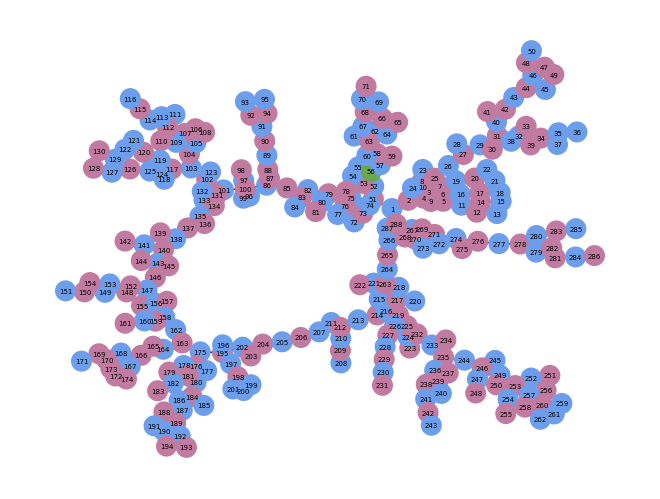

In [11]:
# Visualize the network
curr_model.draw()

In [ ]:
# Simulate and save results
df = curr_model.simulate(n = 864, in_order = True)
df.to_csv("df_female.csv")

In [ ]:
# Download results
files.download("df.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df = pd.read_csv('df_female.csv')
df_nodes = df.groupby('starting_nodes')["days_to_full"].mean()
df_nodes.to_csv('df.csv')


In [ ]:
# Viz sim results
df = pd.read_csv('df_female.csv')
df.agg(df.days_to_full)
days = list(df.days_to_full)
print(days)
curr_model.draw(color_list = days)

In [ ]:
# Save hi-def drawing of the network
f = plt.figure()
f.set_figwidth(16)
f.set_figheight(9)
curr_model.reset()
curr_model.draw()
f.savefig("name.png", dpi = 600)
files.download("name.png")

In [ ]:
# Get sim results
df = pd.read_csv('df_name.csv')
print(df['col_name'].mean())